In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.linear_model import LogisticRegression

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
model_path = "runs/20241115-172401/model_1990000.pt"
model = QNetwork(model_path=model_path)

action_names = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']
activation_layers = [1, 3, 5, 8]

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loaded model: 20241115-172401-1990000


In [4]:
def prepare_probe(concept, model, layer, max_size=10000):
    concept.prepare_data(env_steps, max_size=max_size)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)

    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_weights = lr.coef_[0]
    norm_direction = flat_weights #/ np.linalg.norm(flat_weights)

    return lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy

In [5]:
def compute_tcav_scores(model, layer, norm_direction, acts_dict_test, q_value_strategy):
    test_activations = acts_dict_test[layer]
    test_activations.requires_grad_(True)

    # Apply the Q-value strategy to get Q-values
    q_values = q_value_strategy(model, test_activations, layer)
    q_values.backward(torch.ones_like(q_values))

    activations_grad = test_activations.grad.clone()
    test_activations.requires_grad_(False)

    # Zero gradients to prevent accumulation
    for param in model.network[layer + 1:].parameters():
        if param.grad is not None:
            param.grad.zero_()

    flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
    directional_derivatives = np.dot(flat_activations_grad, norm_direction)

    positive_fraction = np.mean(directional_derivatives > 0)
    return positive_fraction, directional_derivatives

In [6]:
def q_value_per_action(model, activations, layer, action_idx):
    q_values = model.network[layer + 1:](activations)[:, action_idx]
    return q_values

def q_value_softmax(model, activations, layer, action_idx):
    q_values = model.network[layer + 1:](activations).softmax(dim=1)[:, action_idx]
    return q_values

def q_value_max_output(model, activations, layer):
    q_vals = model.network[layer + 1:](activations).max(dim=1)[0]
    return q_vals

def q_value_ratio(model, activations, layer, action1_idx, action2_idx):
    q_vals = model.network[layer + 1:](activations)
    ratio = q_vals[:, action1_idx] / (q_vals[:, action1_idx] + q_vals[:, action2_idx])
    return ratio

In [18]:
def tcav_analysis(concept, model, layers, q_value_strategy, q_strategy_params=None, method_name='TCAV'):
    if q_strategy_params is None:
        q_strategy_params = {}

    scores = []
    directional_derivatives_all_layers = []
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for ax, layer in zip(axes, layers):
        # Prepare probe and get necessary components
        lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept, model, layer)

        # Define a lambda to include additional parameters if any
        q_strategy = lambda m, a, l: q_value_strategy(m, a, l, **q_strategy_params)

        # Compute TCAV scores
        positive_fraction, directional_derivatives = compute_tcav_scores(
            model, layer, norm_direction, acts_dict_test, q_strategy
        )
        scores.append(positive_fraction)
        directional_derivatives_all_layers.append(directional_derivatives)

        # Plotting with smooth distributions using KDE if it is not layer 8
        if layer != 8:
            sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True)
        else:
            ax.hist(directional_derivatives, bins=30, edgecolor='black')
        ax.set_xlabel('Conceptual Sensitivity')
        ax.set_ylabel('Density')
        ax.set_title(f"{concept.name} | {method_name} Layer {layer} | Concept Score: {probe_accuracy:.2f} | TCAV Score: {positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')

    # Hide any unused subplots
    for ax in axes[len(layers):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def tcav_multiple_actions_analysis(concept, model, layers, action_names, q_value_strategy, q_strategy_params=None, method_name='TCAV'):
    if q_strategy_params is None:
        q_strategy_params = {}

    scores_per_layer = {layer: {} for layer in layers}
    directional_derivatives_all_layers = {layer: {} for layer in layers}
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()

    for ax, layer in zip(axes, layers):
        # Prepare probe and get necessary components
        lr, norm_direction, acts_dict_train, acts_dict_test, probe_accuracy = prepare_probe(concept, model, layer)

        # Iterate over each action
        for action_idx, action_name in enumerate(action_names):
            # Define a lambda to include additional parameters if any
            q_strategy = lambda m, a, l: q_value_strategy(m, a, l, action_idx=action_idx)

            # Compute TCAV scores
            positive_fraction, directional_derivatives = compute_tcav_scores(
                model, layer, norm_direction, acts_dict_test, q_strategy
            )
            scores_per_layer[layer][action_name] = positive_fraction
            directional_derivatives_all_layers[layer][action_name] = directional_derivatives

            # Plotting with smooth distributions using KDE
            sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True, label=f"{action_name} (Score: {positive_fraction:.2f})")

        # Customize the subplot
        ax.set_xlabel('Conceptual Sensitivity')
        ax.set_ylabel('Density')
        ax.set_title(f"{concept.name} | {method_name} | Layer {layer} | Concept Score: {probe_accuracy:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        ax.legend()

    # Hide any unused subplots
    for ax in axes[len(layers):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## PLOTTING TIME!

/tmp/ipykernel_1157647/507535887.py:67: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True, label=f"{action_name} (Score: {positive_fraction:.2f})")


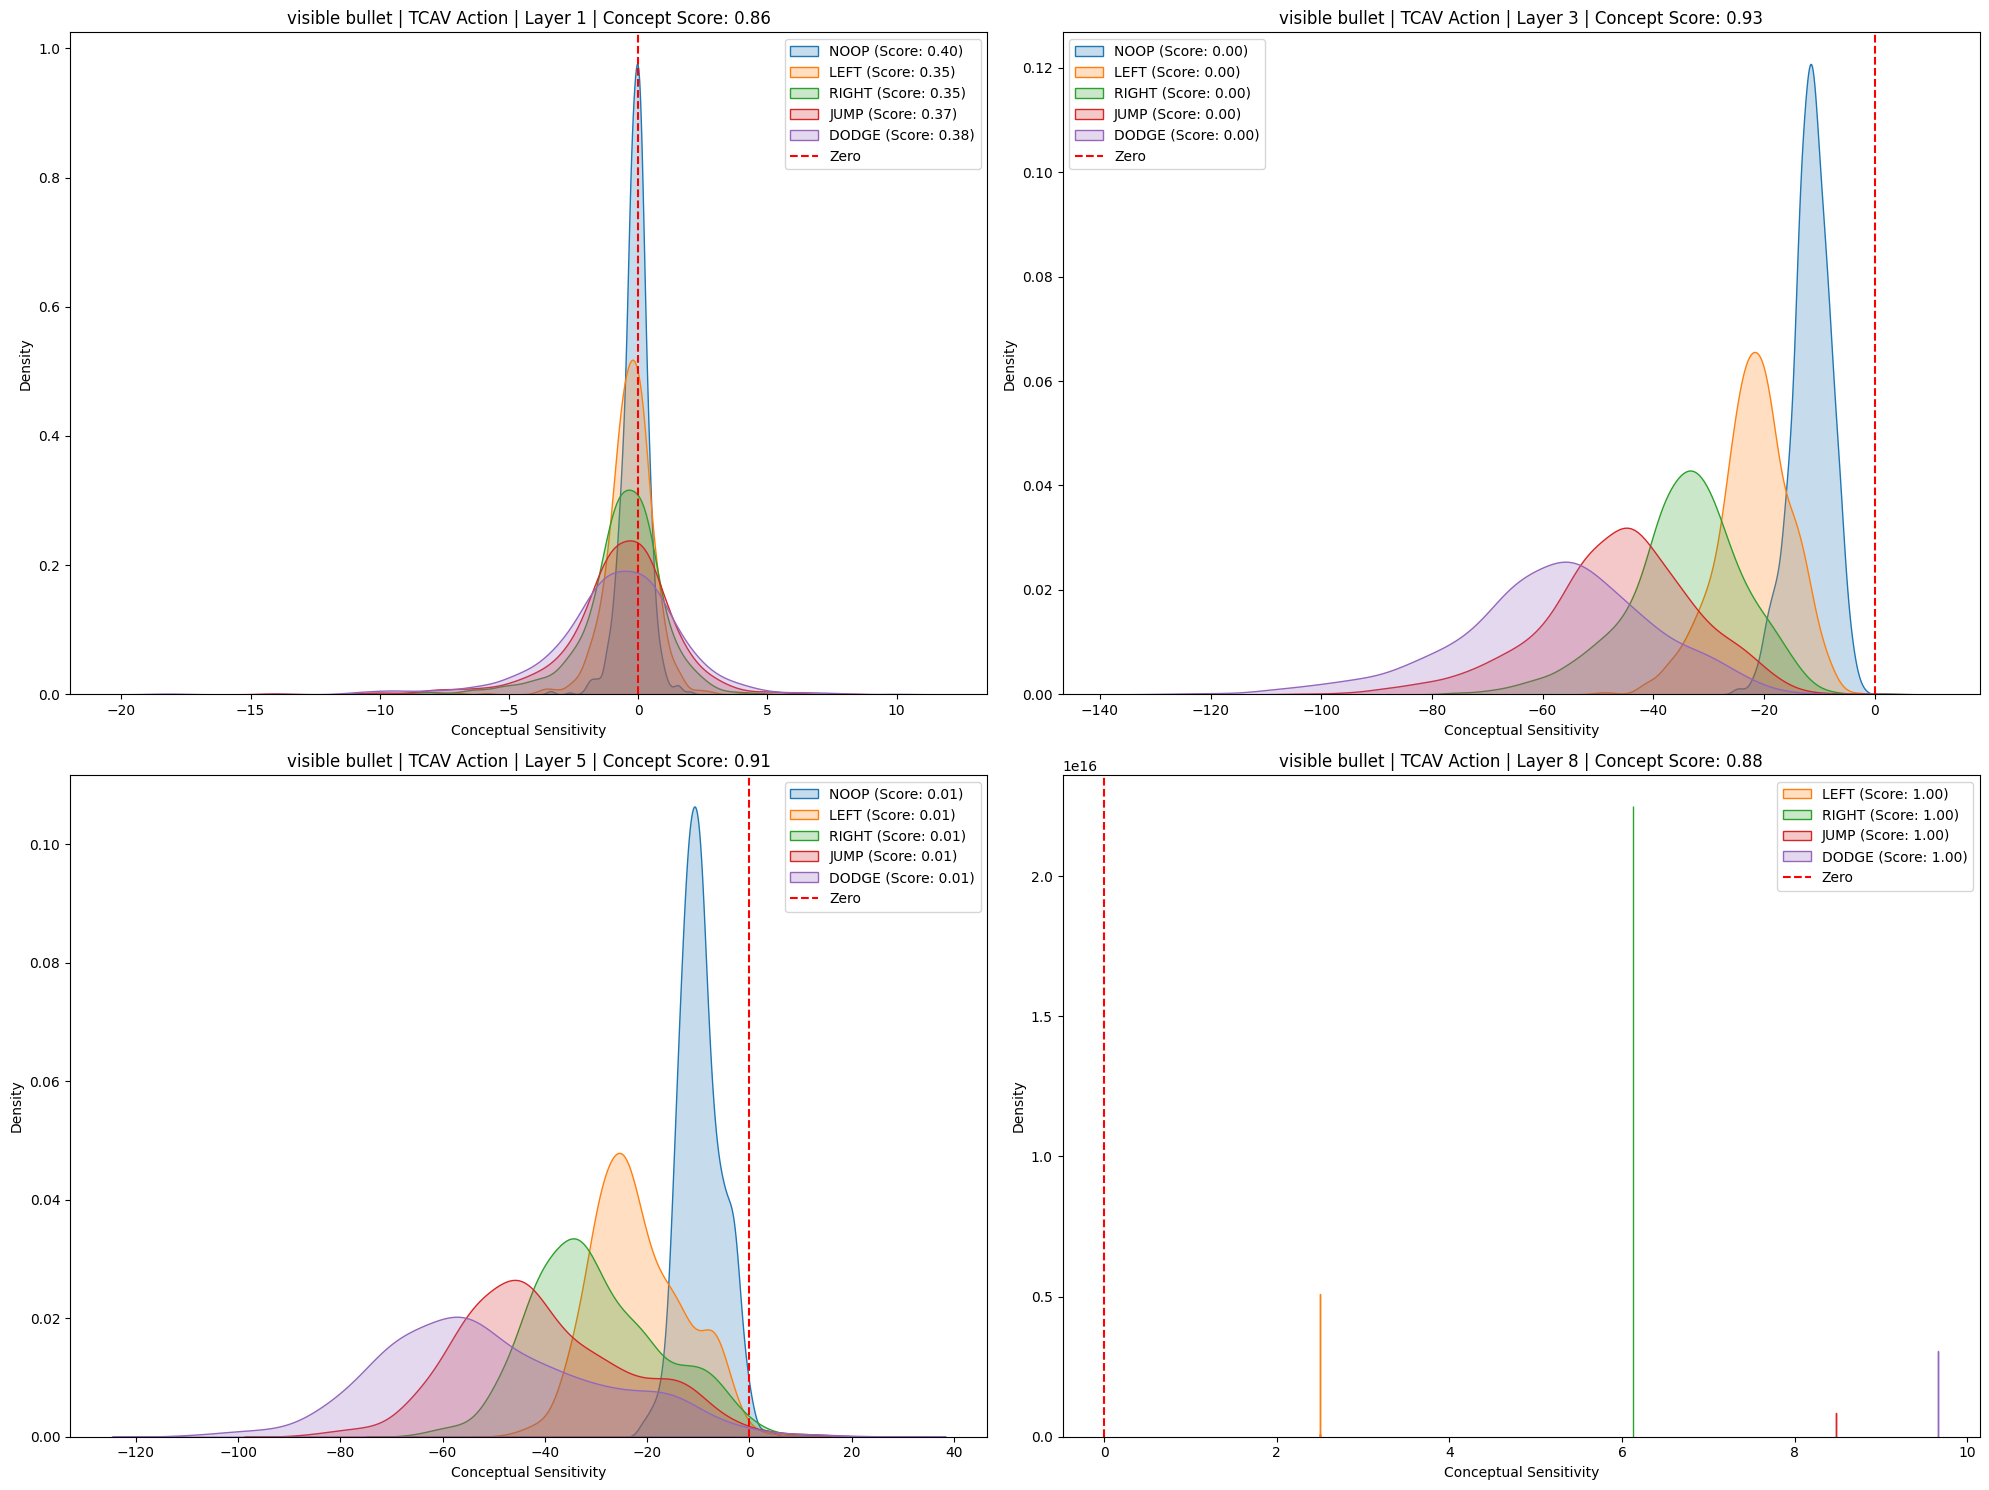

In [24]:
concept = concept_instances['Visible bullet']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_per_action,
    method_name="TCAV Action"
)

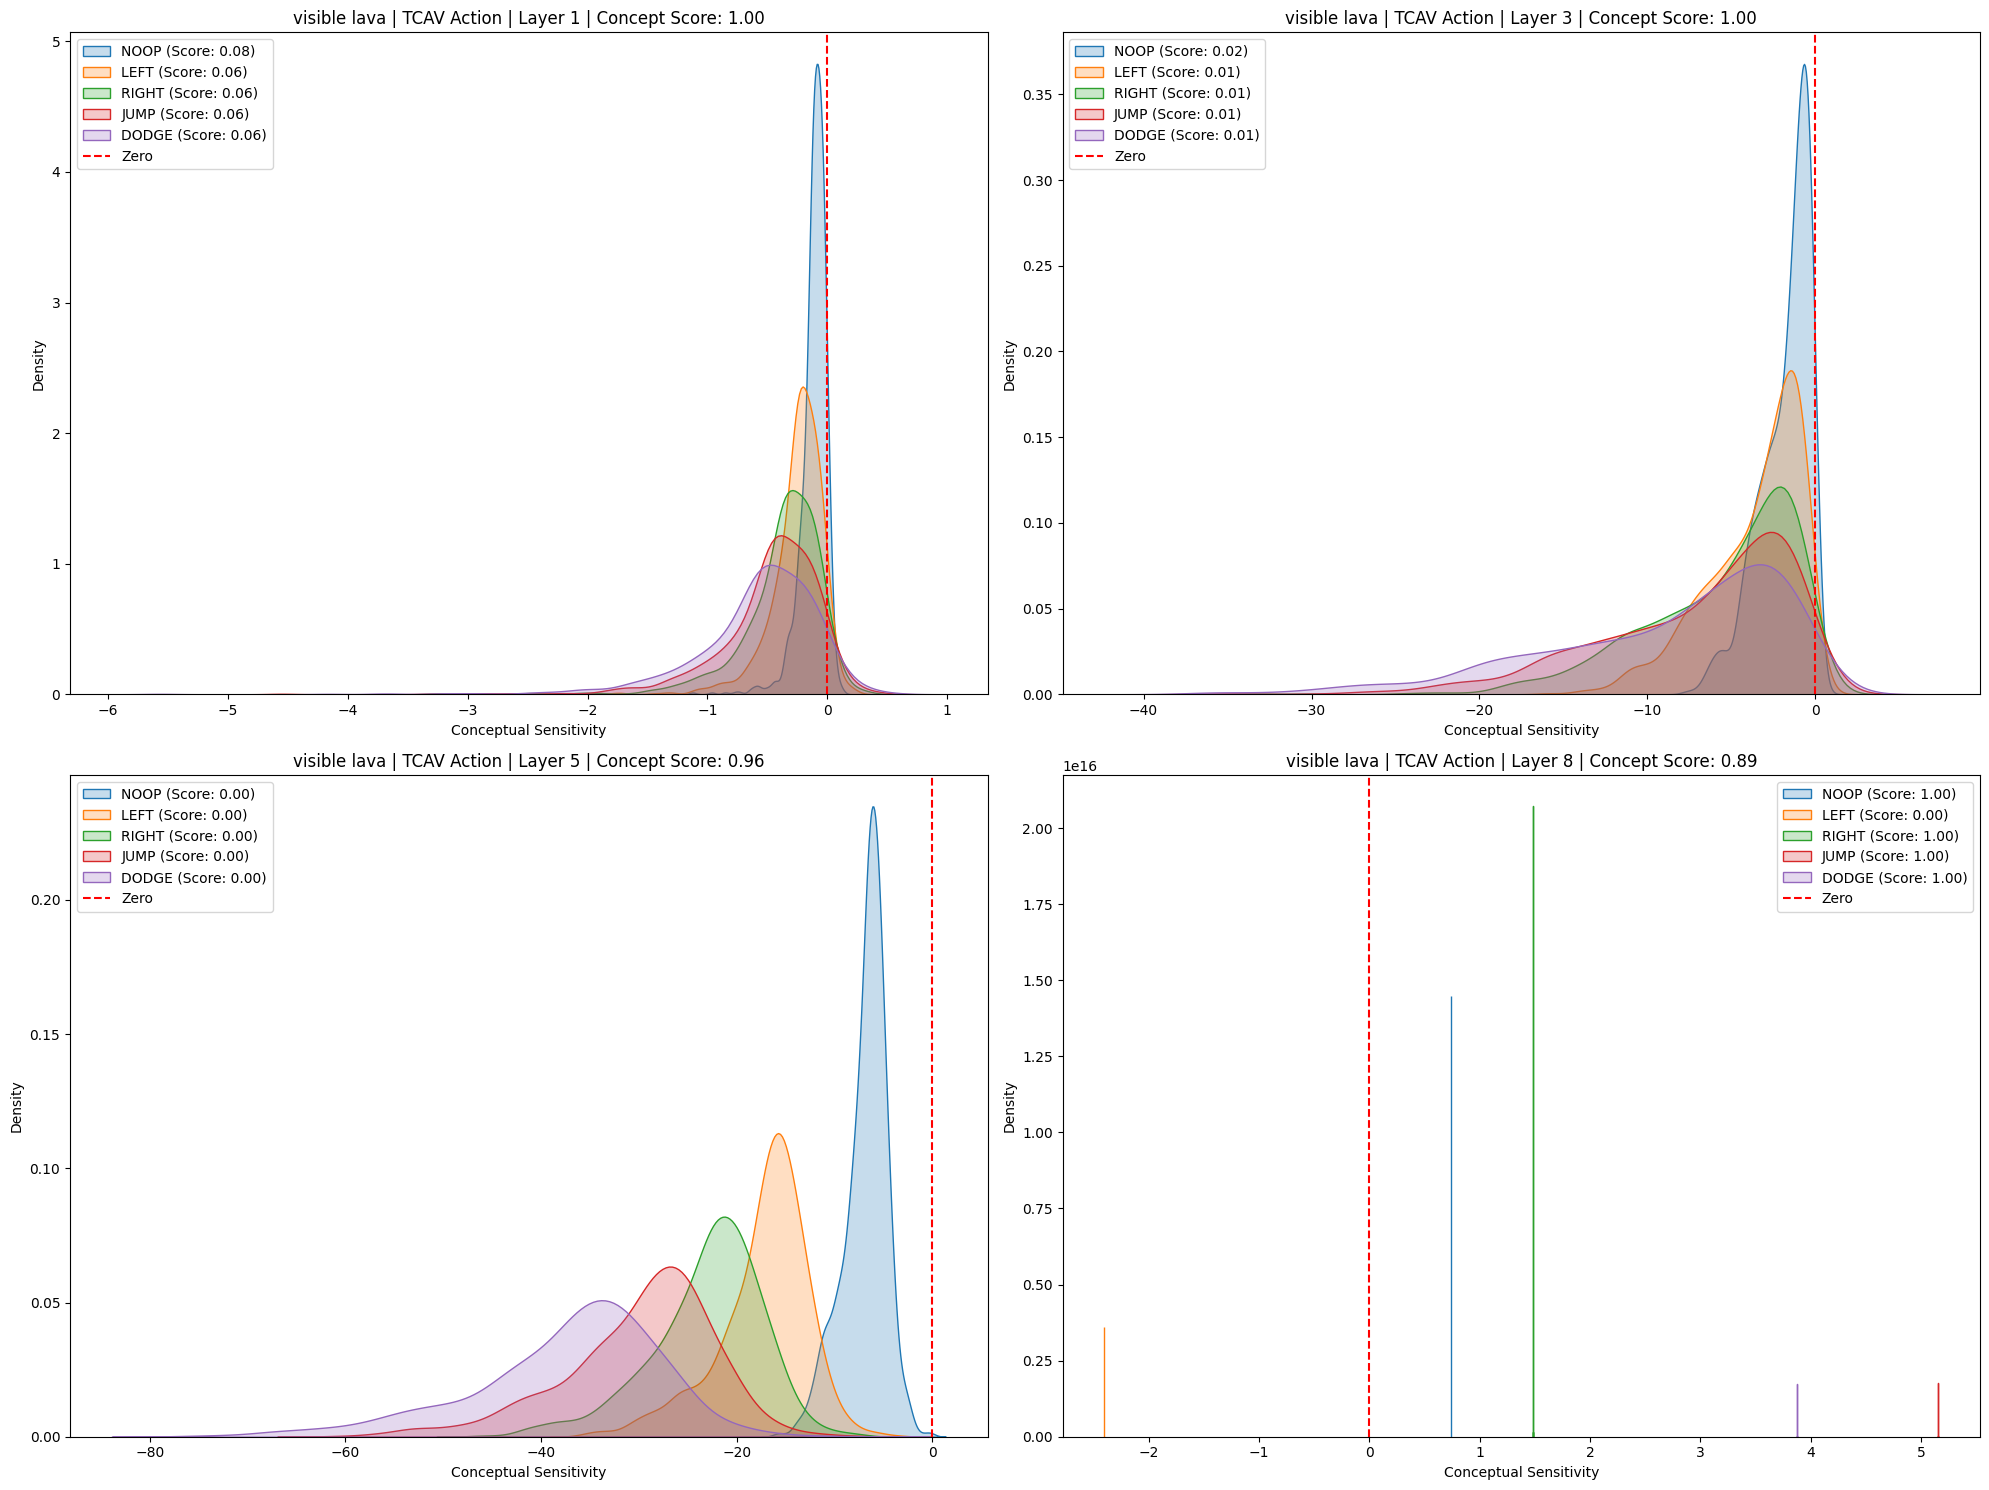

In [19]:
concept = concept_instances['Visible lava']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_per_action,
    method_name="TCAV Action"
)

/tmp/ipykernel_1157647/507535887.py:67: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True, label=f"{action_name} (Score: {positive_fraction:.2f})")
/tmp/ipykernel_1157647/507535887.py:67: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True, label=f"{action_name} (Score: {positive_fraction:.2f})")
/tmp/ipykernel_1157647/507535887.py:67: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(directional_derivatives, bw_adjust=1, ax=ax, fill=True, label=f"{action_name} (Score: {positive_fraction:.2f})")


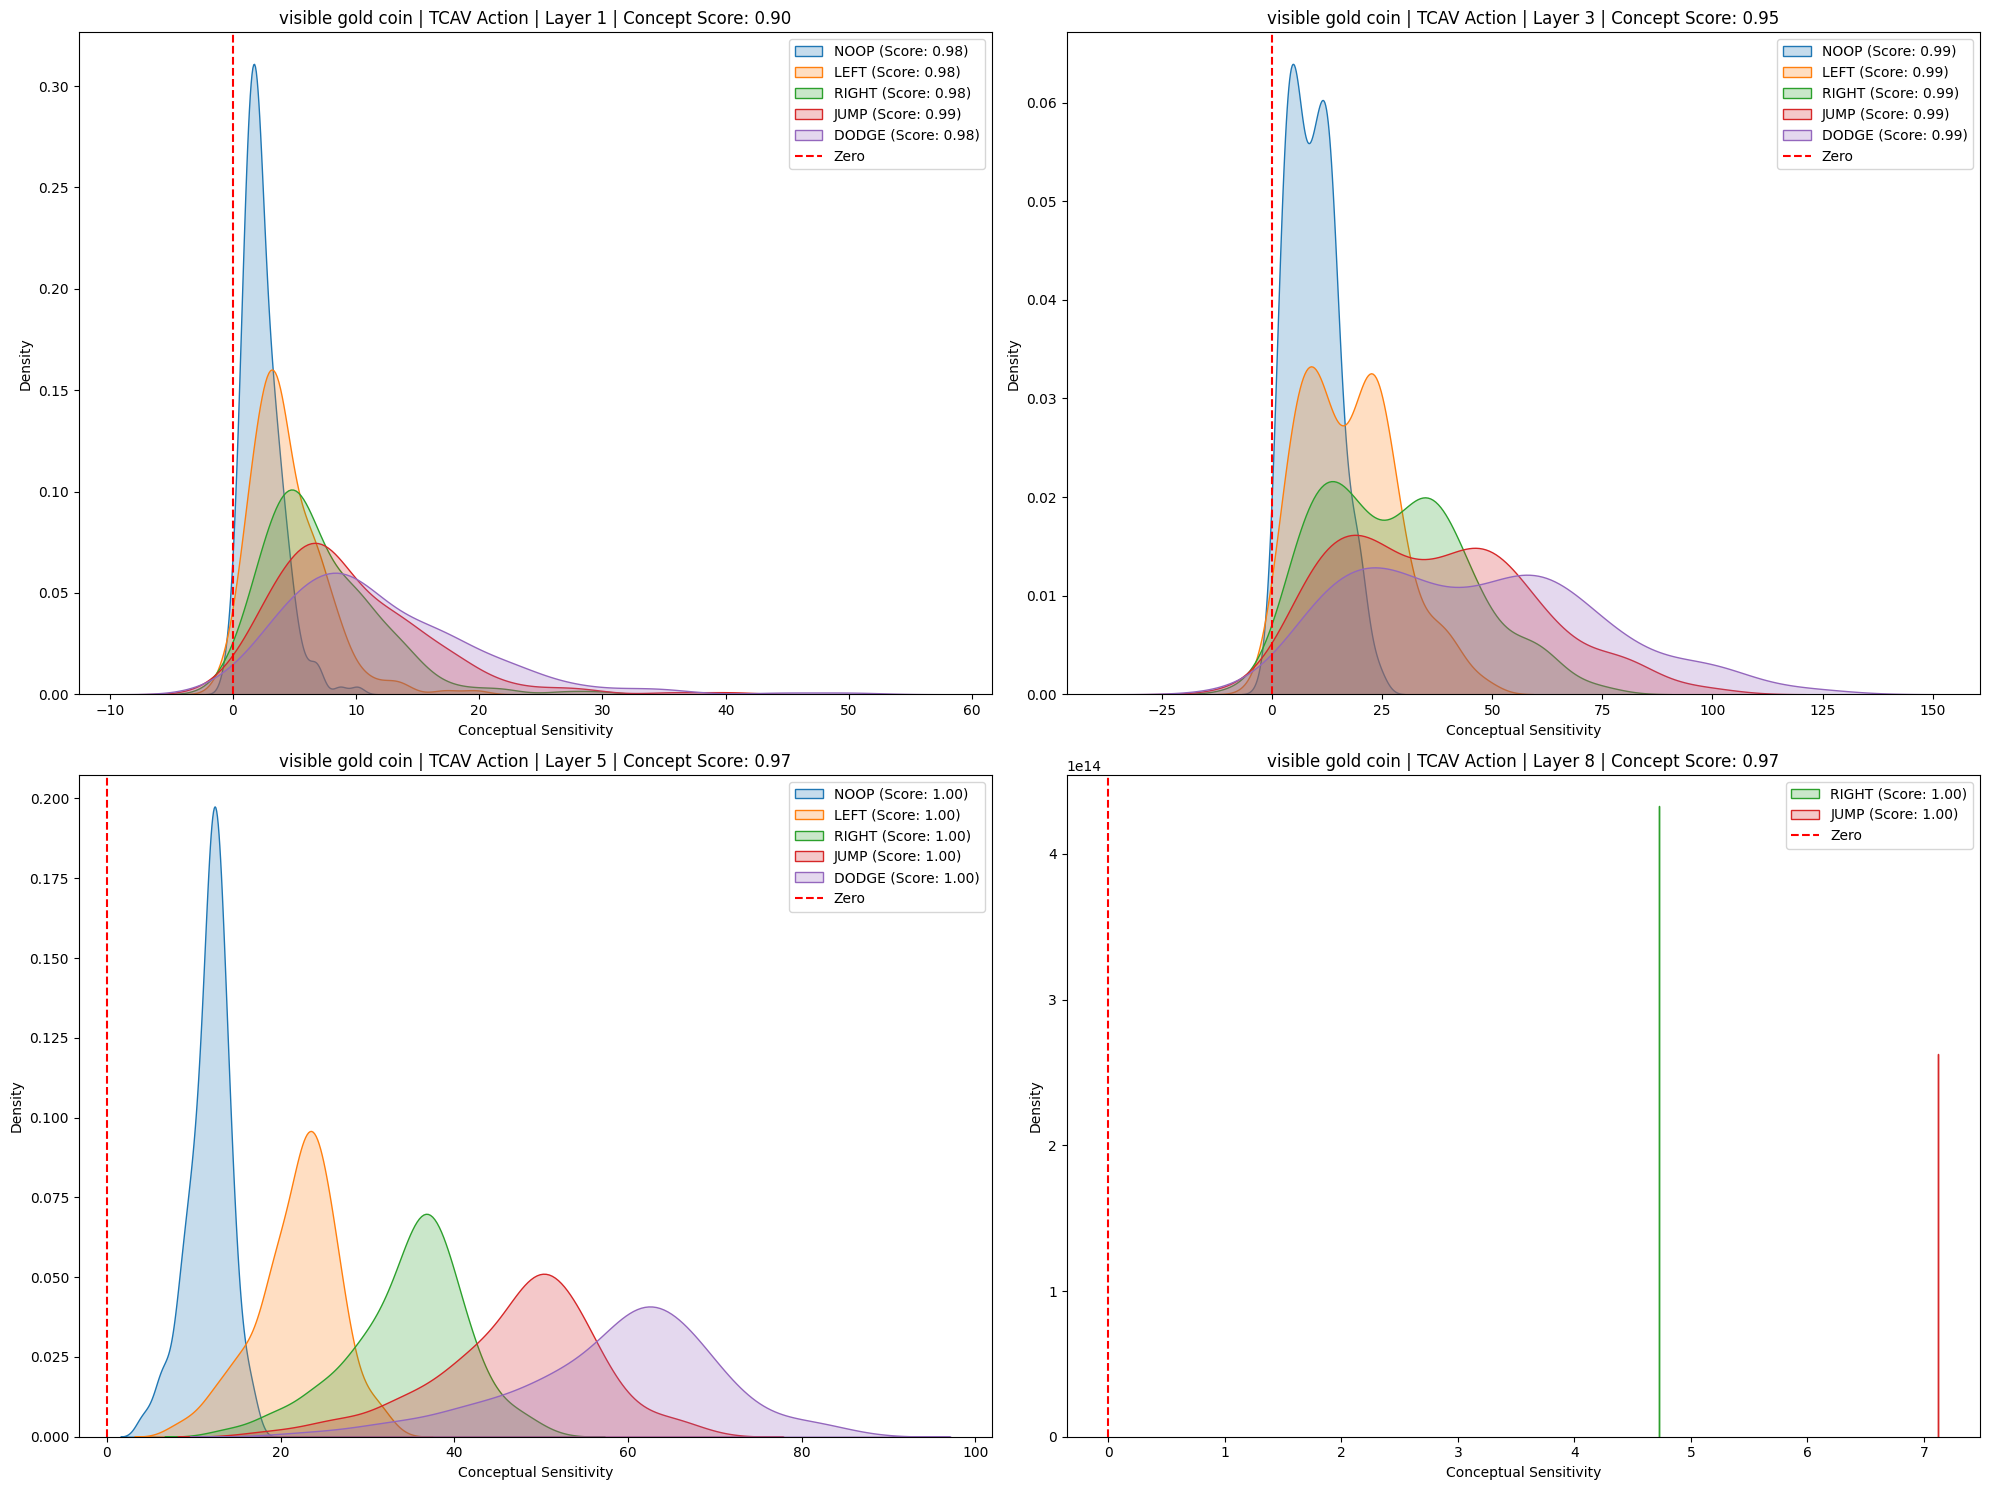

In [15]:
concept = concept_instances['Visible gold coin']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=action_names,
    q_value_strategy=q_value_per_action,
    method_name="TCAV Action"
)

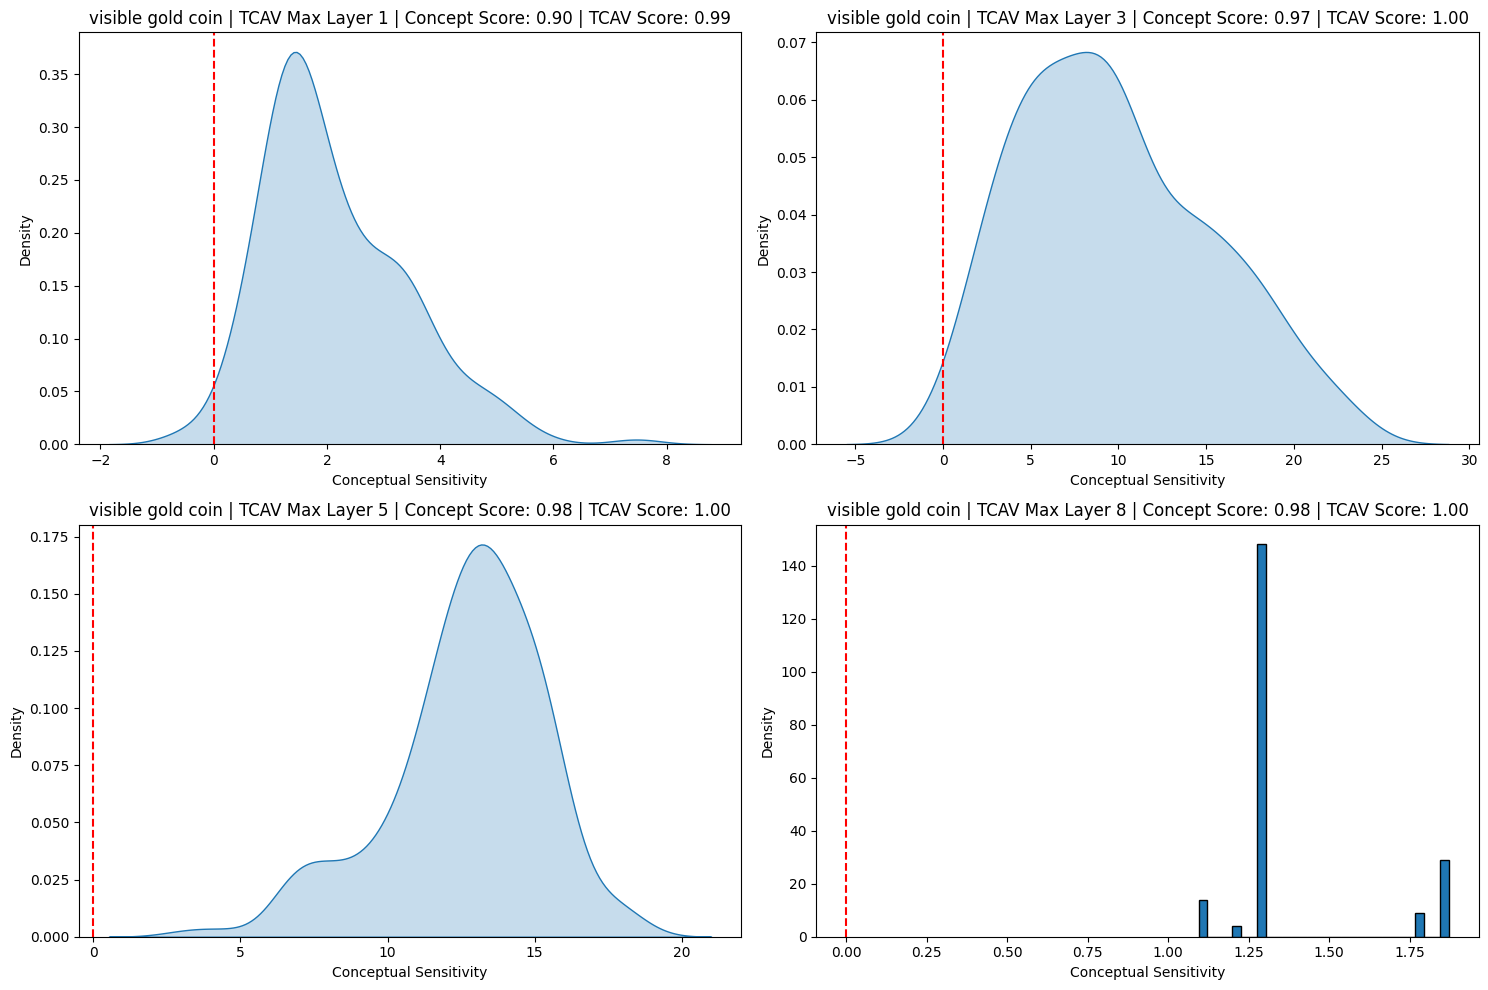

In [10]:
concept = concept_instances['Visible gold coin']

tcav_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    q_value_strategy=q_value_max_output,
    method_name="TCAV Max"
)

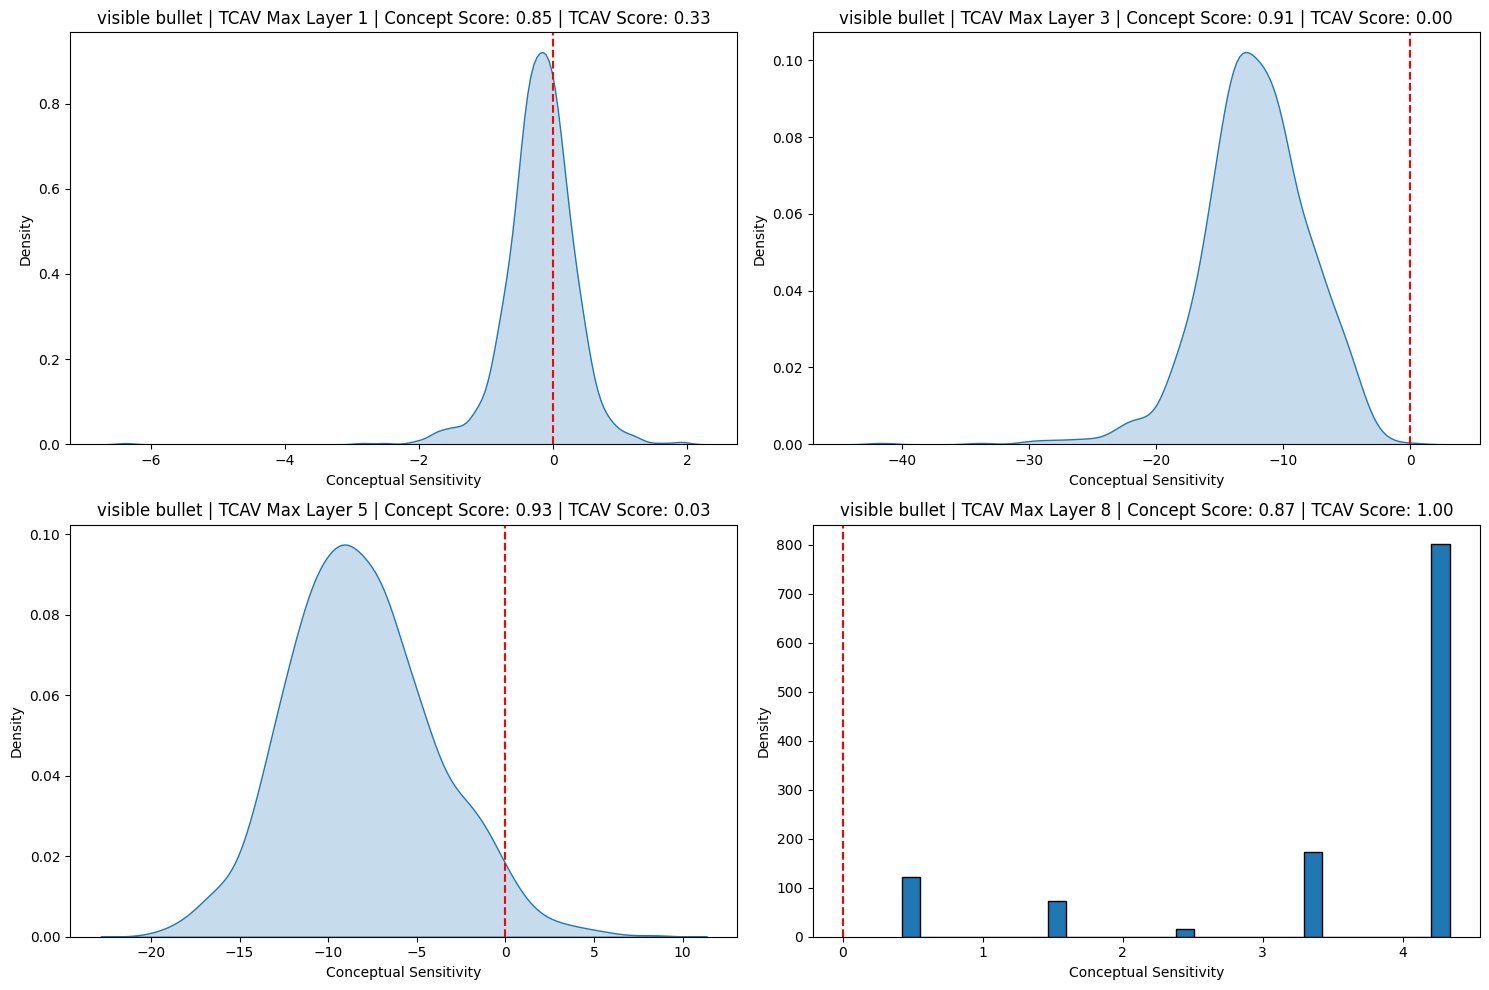

In [20]:
concept = concept_instances['Visible bullet']

tcav_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    q_value_strategy=q_value_max_output,
    method_name="TCAV Max"
)

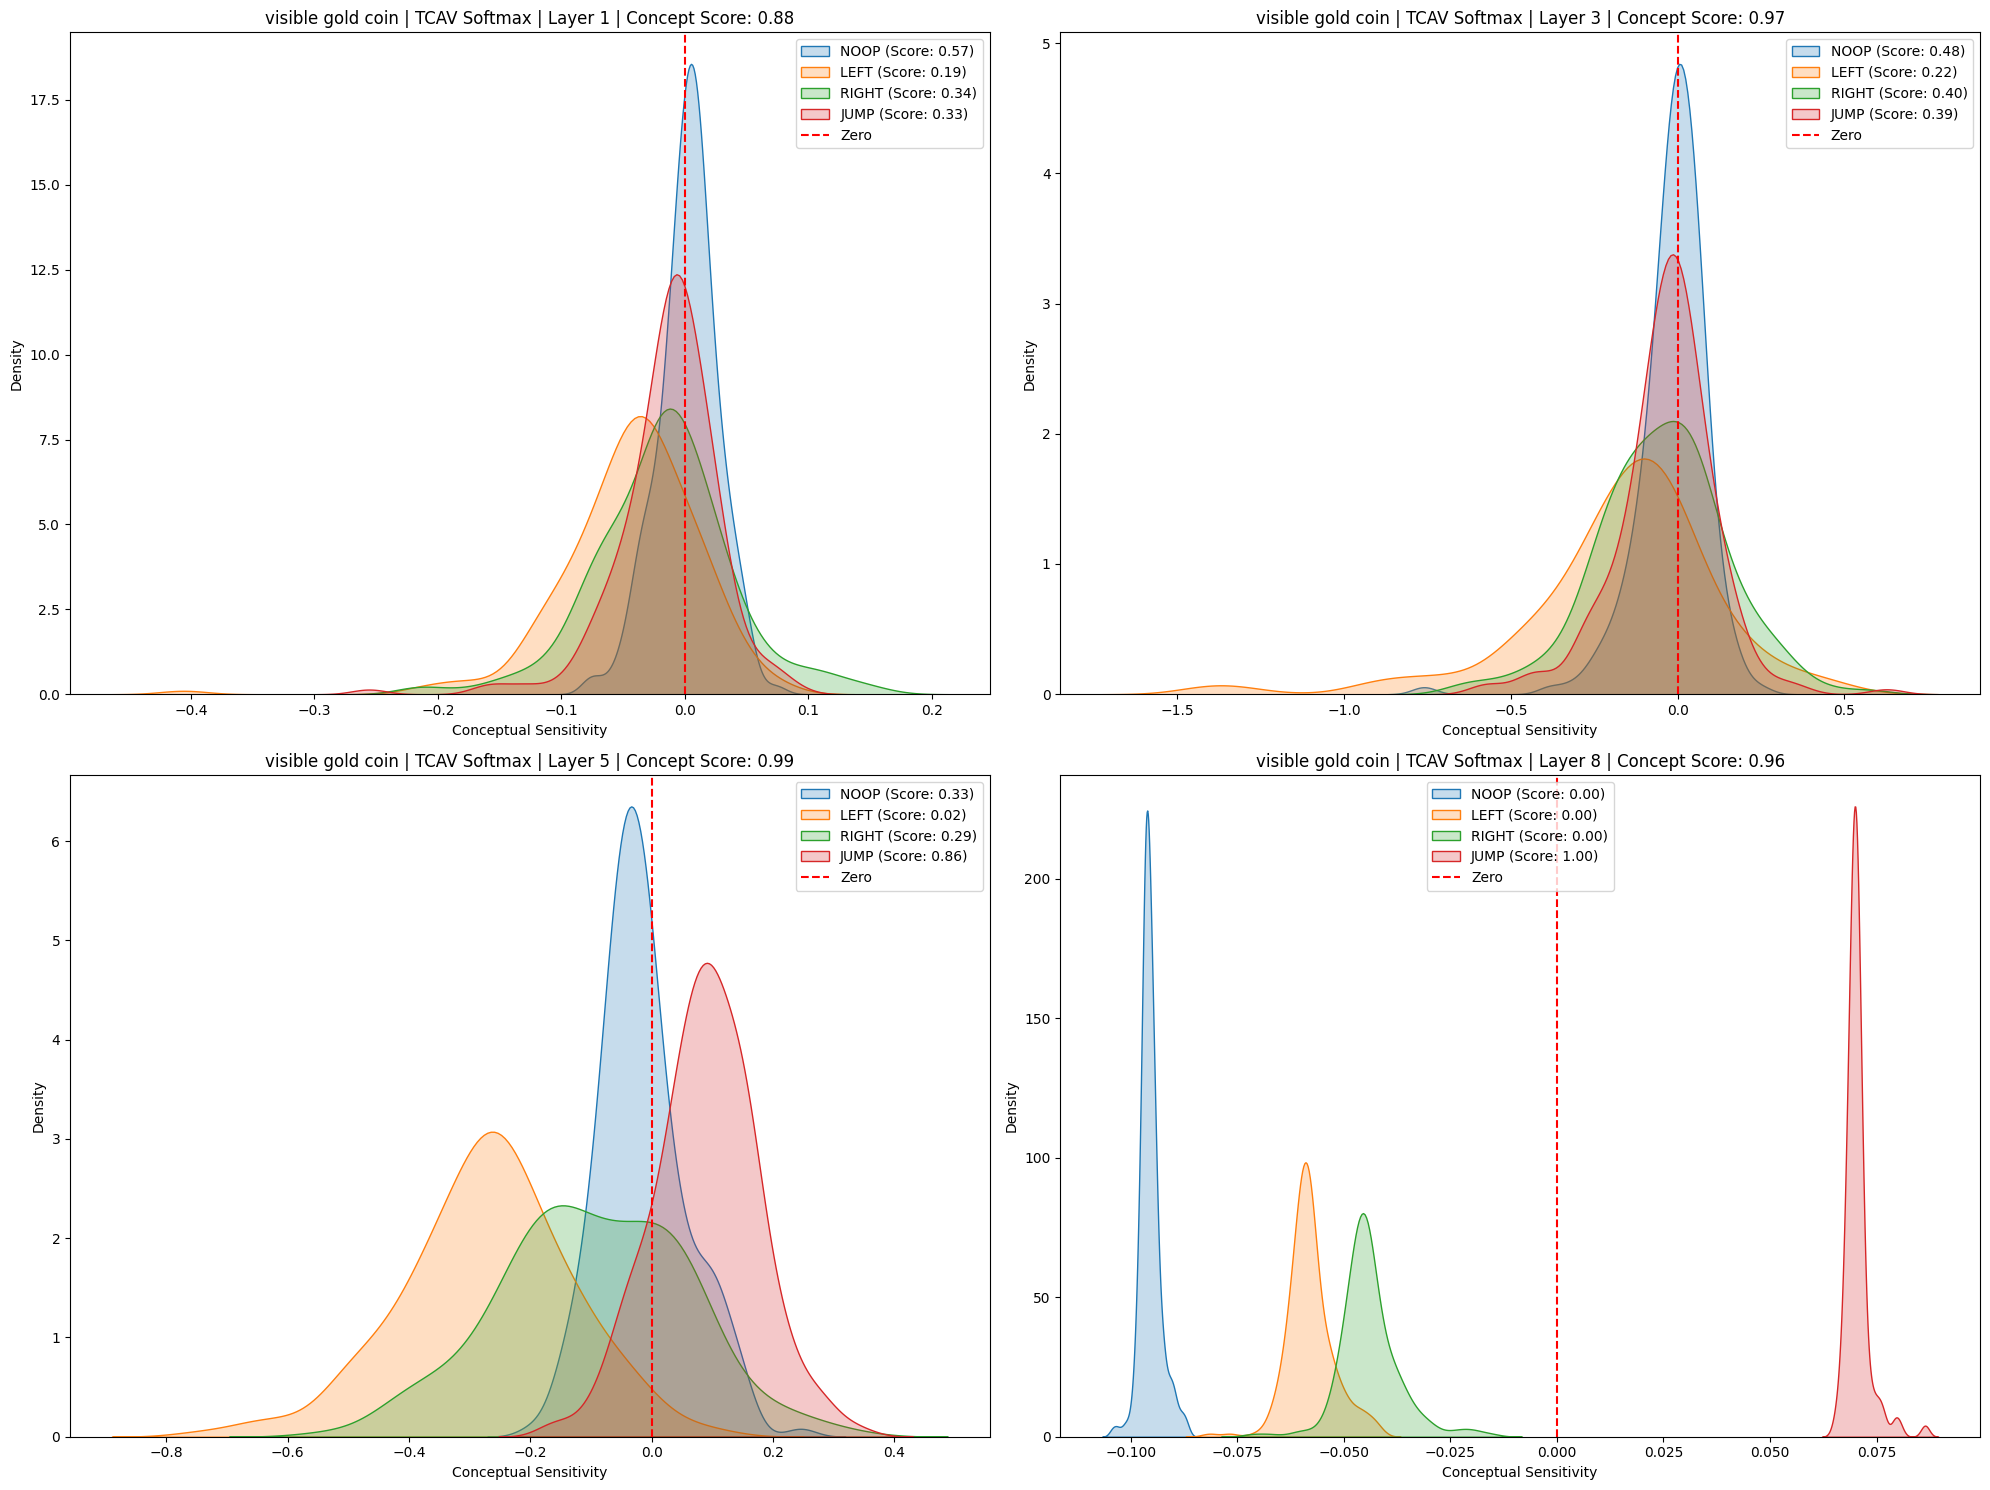

In [21]:
concept = concept_instances['Visible gold coin']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=['NOOP', 'LEFT' ,'RIGHT', 'JUMP'],
    q_value_strategy=q_value_softmax,
    method_name="TCAV Softmax"
)

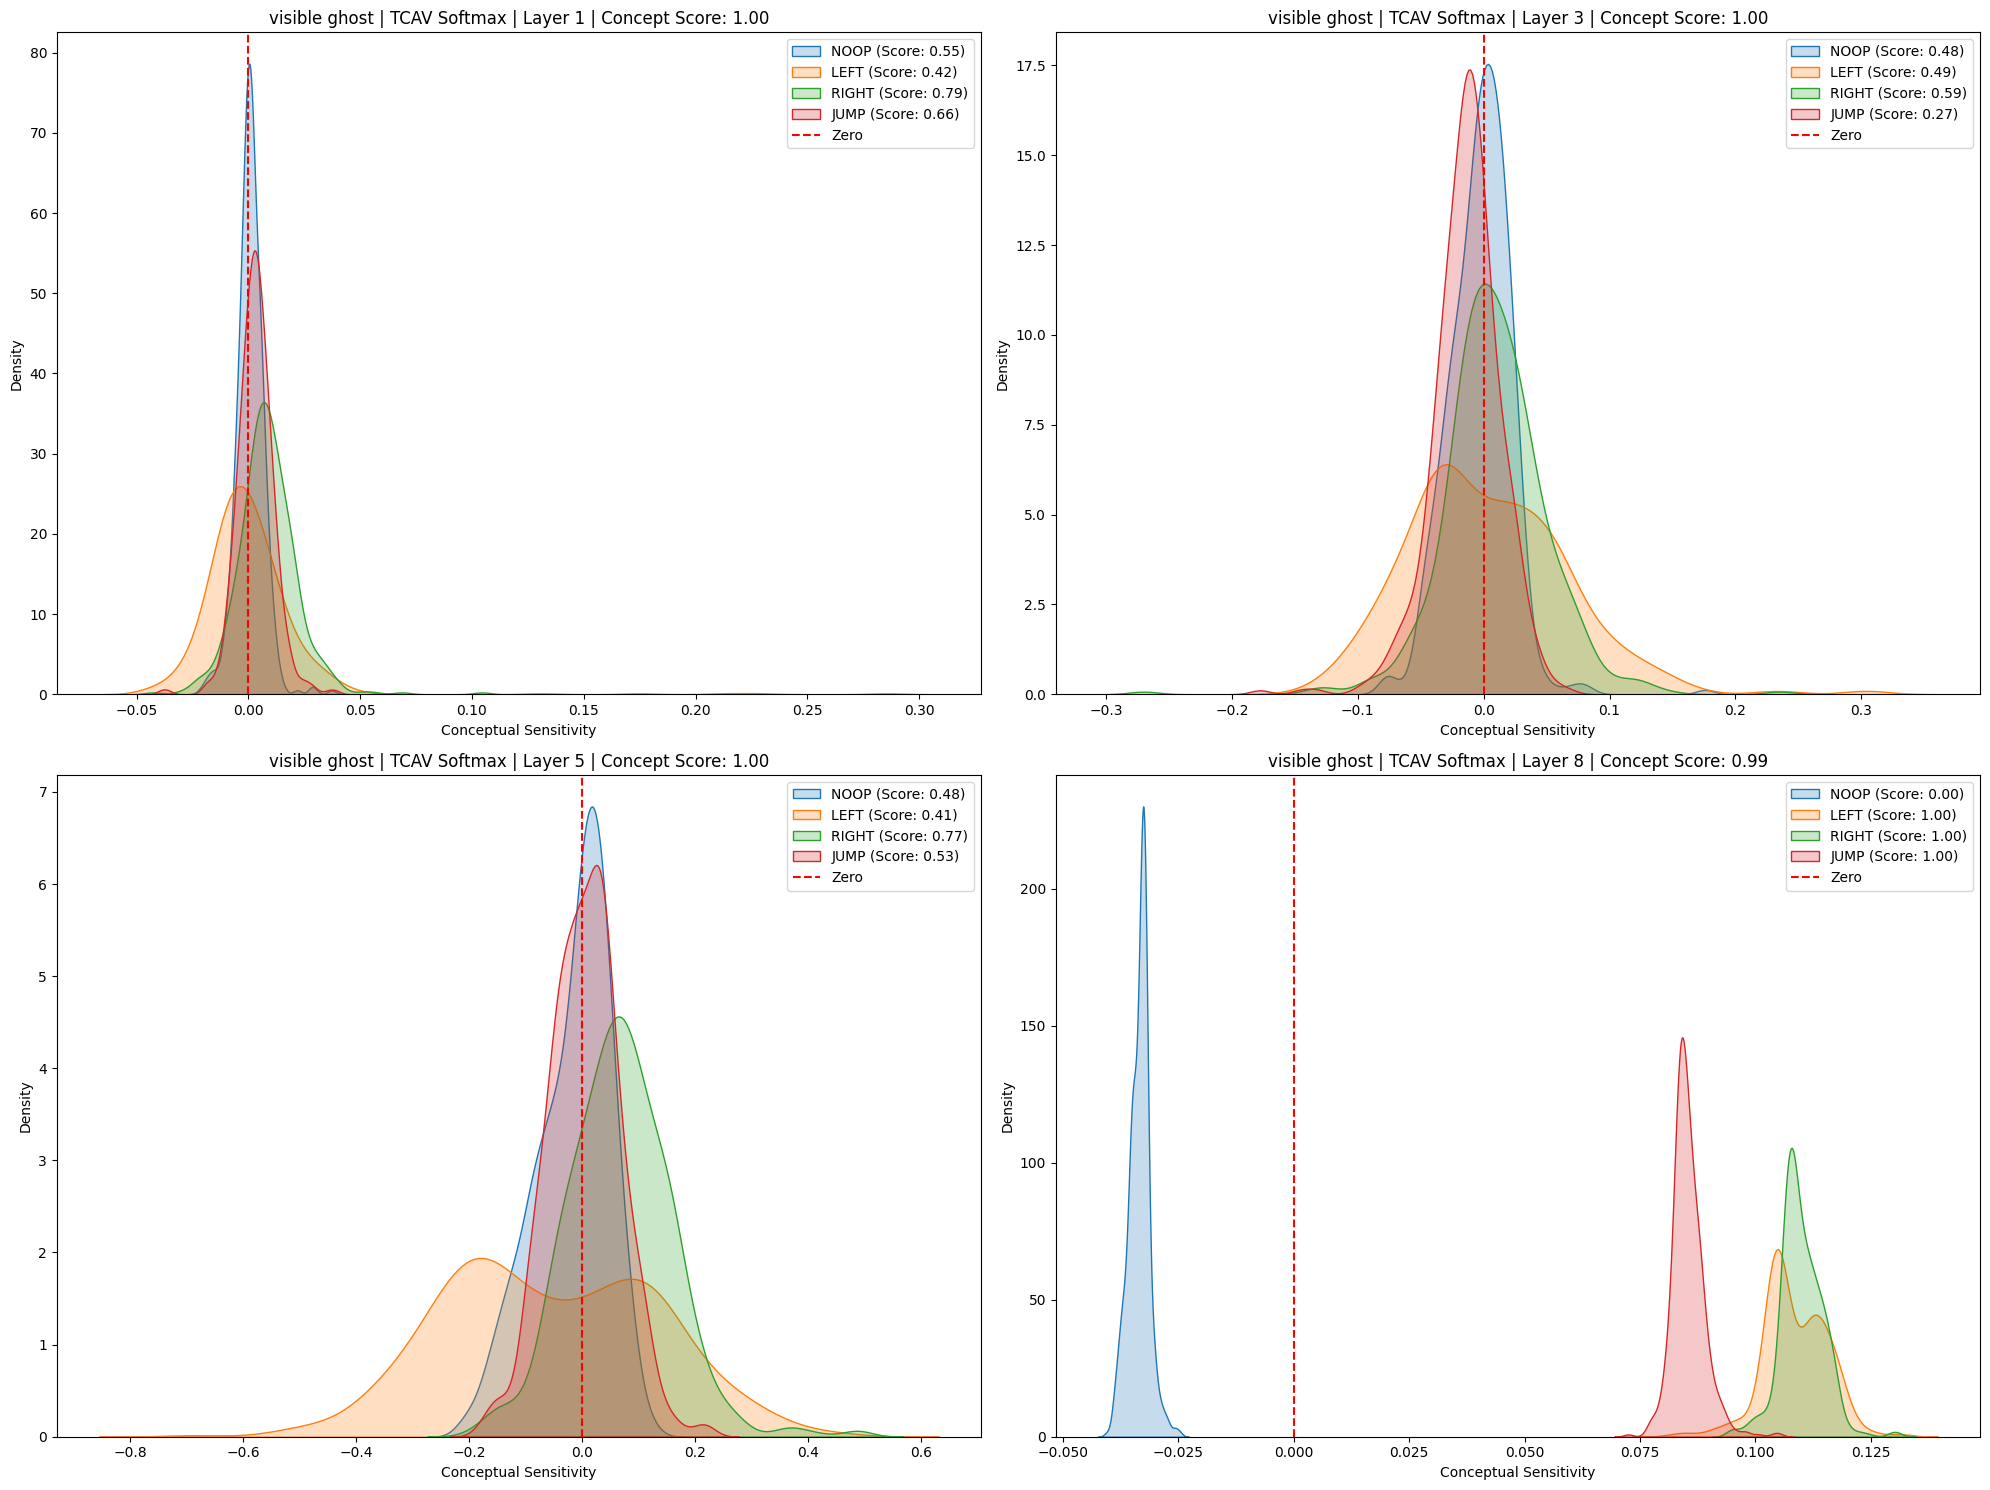

In [22]:
concept = concept_instances['Visible ghost']

tcav_multiple_actions_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    action_names=['NOOP', 'LEFT' ,'RIGHT', 'JUMP'],
    q_value_strategy=q_value_softmax,
    method_name="TCAV Softmax"
)

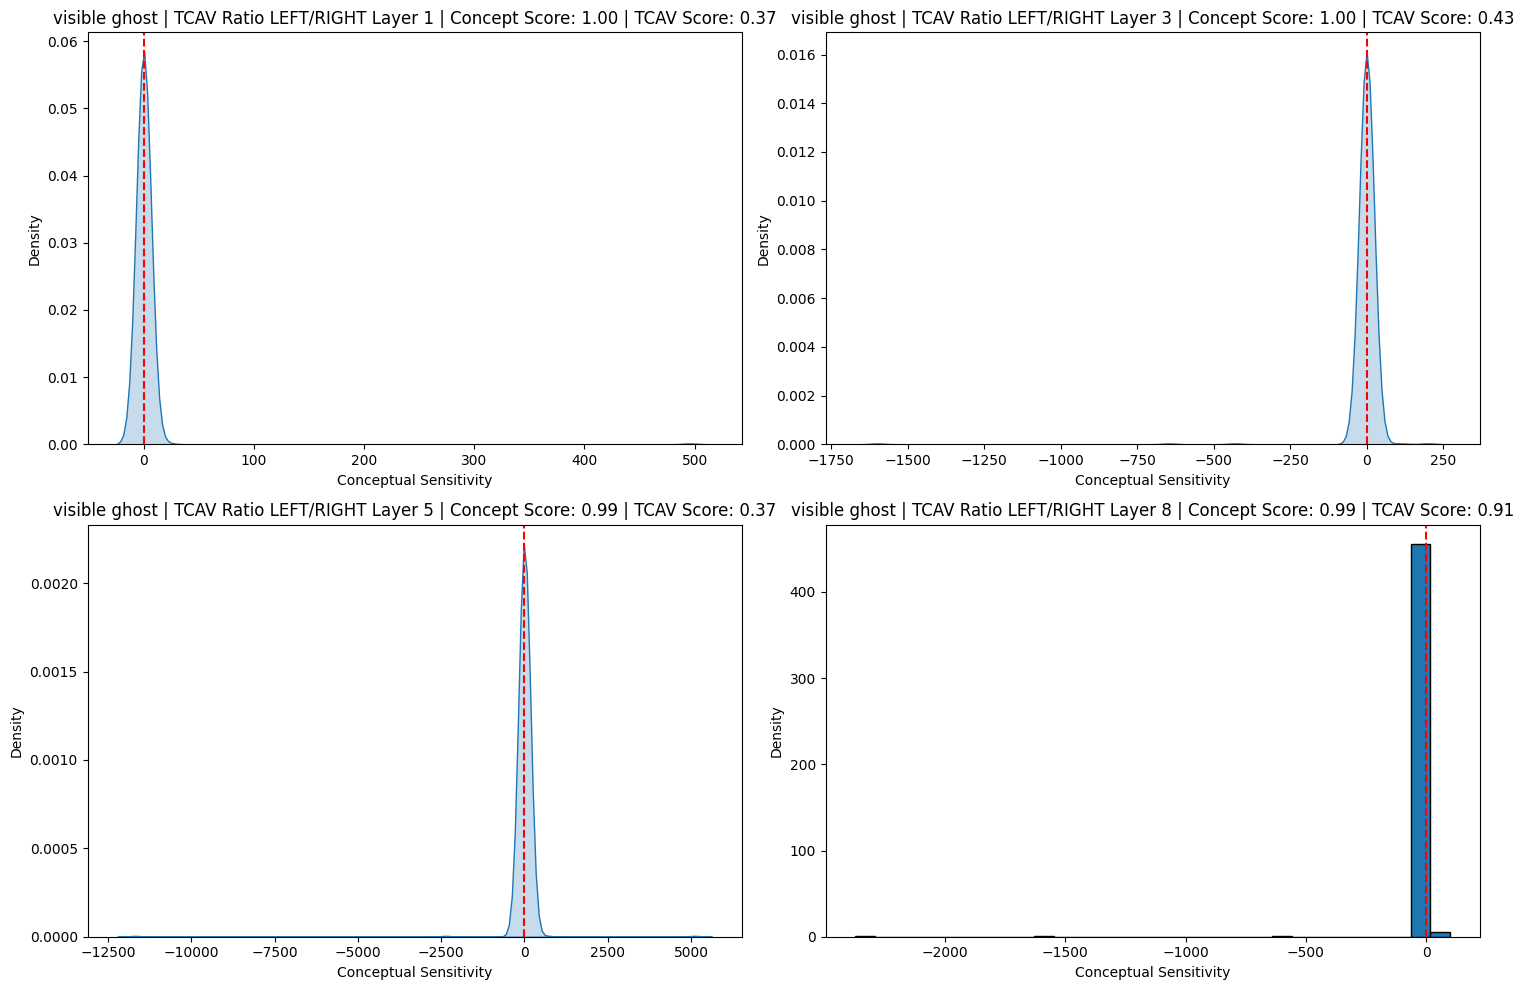

In [23]:
concept = concept_instances['Visible ghost']

action1 = 'LEFT'
action2 = 'RIGHT'
action1_idx = action_names.index(action1)
action2_idx = action_names.index(action2)

scores_tcav_ratio = tcav_analysis(
    concept=concept,
    model=model,
    layers=activation_layers,
    q_value_strategy=q_value_ratio,
    q_strategy_params={'action1_idx': action1_idx, 'action2_idx': action2_idx},
    method_name=f"TCAV Ratio {action1}/{action2}"
)